In [ ]:
# !pip install opencv-python==4.5.5.64
# ! pip install tifffile

In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image
import tifffile
from torchvision import transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification
from glob import glob
import random
import matplotlib.pyplot as plt

2024-11-04 00:05:45.309360: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 00:05:45.309388: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 00:05:45.309407: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 00:05:45.316219: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-04 00:05:46.168777: W tensorflow/compiler/

## Load Trained Model

In [ ]:
device = 'cuda'
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model_name = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(model_name, num_labels=5).to(device)
model.load_state_dict(torch.load('vision_retrained.pth'))

model.eval()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [15]:
def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(0))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but 
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), dim=-1, largest=False)
            indices = indices[indices != 0]
            flat[0, indices] = 0
            
            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result) # [1,197,197]

    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 1:]
    print(mask.size())
#     mask = result[0, 0 , 1 :] # [196,196]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    
    return mask # [14,14] 

In [16]:
class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attention.output.dropout', head_fusion='max', discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)
                print(name)
        self.attentions = []
        
    def get_attention(self, module, input, output):
        self.attentions.append(output[0].cpu())
        
    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)
            
        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [ ]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)  # Normalize to avoid overflow
    return np.uint8(255 * cam)

### Attention Map + Inference for patches in ./image/122_patch
저장 형식: /attention_map/row_col_grade (ex: 29_13_3)

31
Doing Attention Rollout
vit.encoder.layer.0.attention.output.dropout
vit.encoder.layer.1.attention.output.dropout
vit.encoder.layer.2.attention.output.dropout
vit.encoder.layer.3.attention.output.dropout
vit.encoder.layer.4.attention.output.dropout
vit.encoder.layer.5.attention.output.dropout
vit.encoder.layer.6.attention.output.dropout
vit.encoder.layer.7.attention.output.dropout
vit.encoder.layer.8.attention.output.dropout
vit.encoder.layer.9.attention.output.dropout
vit.encoder.layer.10.attention.output.dropout
vit.encoder.layer.11.attention.output.dropout
torch.Size([196])
00090_train_2+.png_attention_map.png


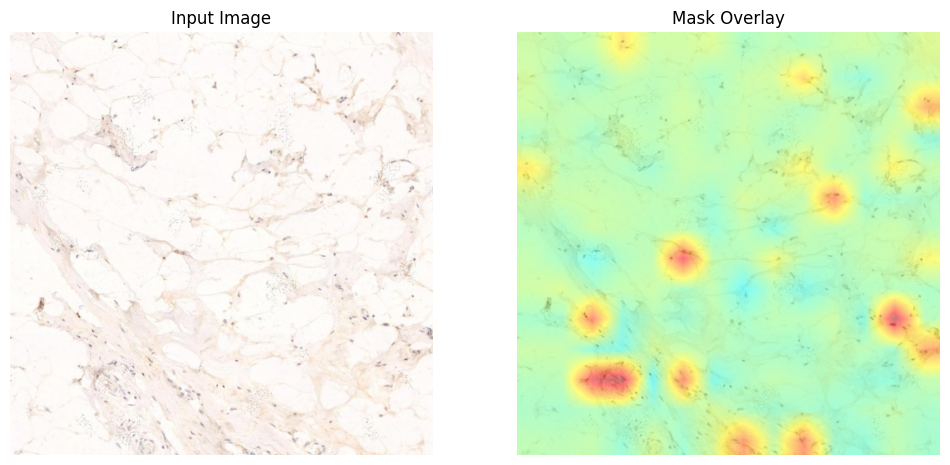

<Figure size 640x480 with 0 Axes>

In [ ]:
img_path_list = glob("./image/122_patch/*")
wsi_path = "./image/122_HER2.tiff"
print("Patch number: ", len(img_path_list))

for i in range(len(img_path_list)):
    img_path = img_path_list[i]
    img_name = img_path.split('/')[-1][:5]
    row = int(img_name.split('_')[0])
    col = int(img_name.split('_')[1])
    
    print(f"Opening {img_name}...")
    image = Image.open(img_path).convert("RGB")
    input_tensor = feature_extractor(images=image, return_tensors="pt")# 이미지 전처리
    input_tensor = input_tensor["pixel_values"]
    input_tensor = input_tensor.cuda()
    
    print("Inference...")
    outputs = model(image).logits
    _, predicted = torch.max(outputs, 1)

    print("Doing Attention Rollout")
    attention_rollout = VITAttentionRollout(model, head_fusion="min", discard_ratio=0)
    mask = attention_rollout(input_tensor)
    save_path = f'./attention_map/{img_name}_{predicted}.png'

    print("Creating Attention Map")
    # Convert the image to a numpy array and change color channels
    np_img = np.array(image)[:, :, ::-1]  # Convert BGR to RGB format for matplotlib

    # Resize the mask to match the input image dimensions
    mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))

    # Apply the mask on the image
    mask_overlay = show_mask_on_image(np_img, mask)
    mask_overlay = mask_overlay[:,:,::-1]
    
    plt.imshow(mask_overlay)
    plt.axis('off')
    plt.savefig(save_path, format='png')
    print(f"Saved {img_name}")

## For checking input image and overlay

In [ ]:
# # Use matplotlib to display the images
# plt.figure(figsize=(12, 6))

# # Display the input image
# plt.subplot(1, 2, 1)
# plt.title("Input Image")
# plt.imshow(image)  # Show the RGB image
# plt.axis("off")  # Hide axis ticks and labels

# # Display the mask overlay
# plt.subplot(1, 2, 2)
# plt.title("Mask Overlay")
# plt.imshow(mask_overlay)  # Show the overlay image
# plt.axis("off")  # Hide axis ticks and labels

# plt.savefig(f"./attention_map/122/{name}.png", format="png")